# Projekt sieci neuronowej przewidującej ceny akcji - część techniczna

### Trening podstawowej sieci neuronowej

In [36]:
from typing import Any, Dict, Pattern, Set, Union, List
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorboard.plugins.hparams import api as hp

In [37]:
def generate_features(df):
    """
    Funkcja generująca cechy na podstawie historycznych wartości indeksu i jego zmienności
    @param df: obiekt DataFrame zawierający kolumny "Open", "Close", "High", "Low", "Volume", "Adjusted Close"
    @return: obiekt DataFrame zawierający zbiór danych z nowymi cechami    
    """
    df_new = pd.DataFrame()
    # 6 oryginalnych cech
    df_new['open'] = df['Open']
    df_new['open_1'] = df['Open'].shift(1)
    df_new['close_1'] = df['Close'].shift(1)
    df_new['high_1'] = df['High'].shift(1)
    df_new['low_1'] = df['Low'].shift(1)
    df_new['volume_1'] = df['Volume'].shift(1)
    # 31 wygenerowanych cech
    # Średnie ceny
    df_new['avg_price_5'] = df['Close'].rolling(5).mean().shift(1)
    df_new['avg_price_30'] = df['Close'].rolling(21).mean().shift(1)
    df_new['avg_price_365'] = df['Close'].rolling(252).mean().shift(1)
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    # Średnie woluminy
    df_new['avg_volume_5'] = df['Volume'].rolling(5).mean().shift(1)
    df_new['avg_volume_30'] = df['Volume'].rolling(21).mean().shift(1)
    df_new['avg_volume_365'] = df['Volume'].rolling(252).mean().shift(1)
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    # Odchylenia standardowe cen
    df_new['std_price_5'] = df['Close'].rolling(5).std().shift(1)
    df_new['std_price_30'] = df['Close'].rolling(21).std().shift(1)
    df_new['std_price_365'] = df['Close'].rolling(252).std().shift(1)
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']
    # Odchylenia standardowe woluminów
    df_new['std_volume_5'] = df['Volume'].rolling(5).std().shift(1)
    df_new['std_volume_30'] = df['Volume'].rolling(21).std().shift(1)
    df_new['std_volume_365'] = df['Volume'].rolling(252).std().shift(1)
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    # Zwroty
    df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
    df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
    df_new['moving_avg_5'] = df_new['return_1'].rolling(5).mean().shift(1)
    df_new['moving_avg_30'] = df_new['return_1'].rolling(21).mean().shift(1)
    df_new['moving_avg_365'] = df_new['return_1'].rolling(252).mean().shift(1)
    # Wartości docelowe
    df_new['close'] = df['Close']
    df_new = df_new.dropna(axis=0)
    return df_new

In [38]:
# Załadowanie danych o akcjach i wywołanie funkcji generate_features, która generuje cechy i etykiety
data_raw = pd.read_csv('./data/sp500/HPQ.csv', index_col='Date')
data = generate_features(data_raw)

In [39]:
# Ustalenie zakresów dat, na które ma być podzielony zbiór danych
start_train = '04-01-1971'
end_train = '31-12-2021'
start_test = '03-01-2022'
end_test = '12-12-2022'

# Utworzenie zbioru treningowego i zbioru testowego
data_train = data.loc[start_train:end_train]
X_train = data_train.drop('close', axis=1).values
y_train = data_train['close'].values
data_test = data.loc[start_test:end_test]
X_test = data_test.drop('close', axis=1).values
y_test = data_test['close'].values

/tmp/ipykernel_26892/915853072.py:8: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data_train = data.loc[start_train:end_train]


In [40]:
# Znormalizowanie cech, aby miały tę samą lub porównywalną skalę. 
# Polega to na odjęciu od nich średniej wartości i przeskalowaniu ich do jednostkowej wariancji.
# Do przeskalowania zbiorów użyto przetrenowanego obiektu scaler
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [41]:
# Ustalenie seedu w celu testowania
tf.random.set_seed(42)

In [82]:
# Zbudowanie sieci neuronowej, wykorzystującą klasę Sequential zawartą w bibliotece Keras. 
# Początkowa sieć składa się z jednej warstwy ukrytej, 
# zbudowanej z 32 węzłów i wykorzystującej funkcję aktywacji ReLU
model = Sequential([
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

# Skomplilowanie modelu sieci, wykorzystując optymalizator Adam. 
# Przyjęta szybkość uczenia się 0.1 i błąd średniokwadratowy jako cel treningu.
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.1))
model.fit(X_scaled_train, y_train, epochs=100, verbose=True)
predictions = model.predict(X_scaled_test)[:, 0]

# Użycie przetrenowanego modelu do przetworzenia zbioru testowego i wyświetlenie wskaźników skuteczności
print(f'Błąd średniokwadratowy: {mean_squared_error(y_test, predictions):.3f}')
print(f'Średni błąd bezwzględny: {mean_absolute_error(y_test, predictions):.3f}')
print(f'R^2: {r2_score(y_test, predictions):.3f}')

Epoch 1/100
402/402 [==============================] - 2s 2ms/step - loss: 2.5788
Epoch 2/100
402/402 [==============================] - 1s 2ms/step - loss: 0.3994
Epoch 3/100
402/402 [==============================] - 1s 2ms/step - loss: 0.4251
Epoch 4/100
402/402 [==============================] - 1s 2ms/step - loss: 0.5603
Epoch 5/100
402/402 [==============================] - 1s 2ms/step - loss: 0.4078
Epoch 6/100
402/402 [==============================] - 1s 2ms/step - loss: 0.2055
Epoch 7/100
402/402 [==============================] - 1s 2ms/step - loss: 0.2311
Epoch 8/100
402/402 [==============================] - 1s 1ms/step - loss: 0.2503
Epoch 9/100
402/402 [==============================] - 1s 1ms/step - loss: 0.2442
Epoch 10/100
402/402 [==============================] - 1s 1ms/step - loss: 0.1911
Epoch 11/100
402/402 [==============================] - 1s 2ms/step - loss: 0.2604
Epoch 12/100
402/402 [==============================] - 1s 1ms/step - loss: 2.0343
Epoch 13/100


##### Uzyskano współczynnik R^2 równy 0.765

### Dostrojenie parametrów sieci neuronowej za pomocą modułu hparams

In [78]:
# Dostosowywana będzie liczba węzłów w ukrytej warstwie, liczbę warstw ukrytych plus wyjściowa, liczba iteracji treningowych i szybkość uczenia.
# Będą to trzy liczby węzłów(wartości dyskretne) równe 13, 32 i 64,
# trzy liczby warstw ukrytych plus wyjściowa równe 2, 3, 5 
# dwie liczby iteracji(wartości dyskretne) równe 300 i 1000 oraz 
# szybkość uczenia(wartość ciągła) z zakresu od 0,01 do 4

HP_HIDDEN = hp.HParam('hidden_size', hp.Discrete([64, 32, 16]))
HP_LAYERS = hp.HParam('layers', hp.Discrete([2, 3, 5]))
HP_EPOCHS = hp.HParam('epochs', hp.Discrete([300, 1000]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.RealInterval(0.01, 0.4))

In [67]:
def train_test_model(hparams: Dict[hp.HParam, Any], logdir: str) -> tuple:
    """
    Funkcja trenująca i testująca model sieci neuronowej
    @param hparams: obiekt słownika zawierający hiperparametry w postaci {nazwa_hiperparametru:wartość}
    @param logdir: ścieżka dla każdej iteracji trenowania i testowania sieci
    @return: mse, r2 - obiekt tuple zawierający wskażniki skuteczności modelu    
    """
    # Założono trenowanie i testowanie sieci neuronowej o 3 architekturach:
    #   - jedna warstwa ukryta
    #   - dwie warstwy ukryte, druga z połową węzłów
    #   - dwie warstwy ukryte, druga z połową węzłów, dodatkowo zostosowamy Dropout o wartości 0.5
    if hparams[HP_LAYERS] == 2:
        layers_list = [Dense(units=hparams[HP_HIDDEN], activation='relu'), Dense(units=1)]
    elif hparams[HP_LAYERS] == 3:
        layers_list = [Dense(units=hparams[HP_HIDDEN], activation='relu'), Dense(units=(hparams[HP_HIDDEN]//2), activation='relu'), Dense(units=1)]
    elif hparams[HP_LAYERS] == 5:
        layers_list = [Dense(units=hparams[HP_HIDDEN], activation='relu'), Dropout(0.5), Dense(units=(hparams[HP_HIDDEN]//2), activation='relu'), Dropout(0.5), Dense(units=1)]

    model = Sequential(layers_list)
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(hparams[HP_LEARNING_RATE]),
                  metrics=['mean_squared_error'])
    model.fit(X_scaled_train, y_train, validation_data=(X_scaled_test, y_test), epochs=hparams[HP_EPOCHS], verbose=False,
              callbacks=[
                  tf.keras.callbacks.TensorBoard(logdir),
                  hp.KerasCallback(logdir, hparams),
                  tf.keras.callbacks.EarlyStopping(
                      monitor='val_loss', min_delta=0, patience=200, verbose=0, mode='auto',
                  )
              ],
              )
    _, mse = model.evaluate(X_scaled_test, y_test)
    pred = model.predict(X_scaled_test)
    r2 = r2_score(y_test, pred)
    return mse, r2

In [68]:
def run(hparams: Dict[hp.HParam, Any], logdir: str) -> None:
    """
    Funkcja inicjująca proces treningu za pomocą kombinacji hiperparametrów oraz wyświetlająca podsumowanie 
    zawierające wartości błędu średniokwadratowego i współczynnika R^2
    @param hparams: obiekt słownika zawierający hiperparametry w postaci {nazwa_hiperparametru:wartość}
    @param logdir: ścieżka dla każdej iteracji trenowania i testowania sieci   
    """
    with tf.summary.create_file_writer(logdir).as_default():
        hp.hparams_config(
            hparams=[HP_HIDDEN, HP_LAYERS, HP_EPOCHS, HP_LEARNING_RATE],
            metrics=[hp.Metric('mean_squared_error', display_name='mse'),
                     hp.Metric('r2', display_name='r2'),
                    ],
        )
        mse, r2 = train_test_model(hparams, logdir)
        tf.summary.scalar('mean_squared_error', mse, step=1)
        tf.summary.scalar('r2', r2, step=1)

In [79]:
# Tworzenie, kompilowanie i trenowanie modelu sieci neuronowej z wszystkimi możliwymi kombinacjami hiperparametrów.
# W każdej próbie są stosowane trzy wartości dyskretne(liczbę węzłów w warstwie ukrytej, liczbę warstw i liczbę iteracji) wybrane ze zdefiniowanych pól 
# oraz jedna wartość ciągła(szybkość uczenia) wybrana z jednego z równych podprzedziałów z założonego zakresu
session_num = 0
for hidden in HP_HIDDEN.domain.values:
    for layers_number in HP_LAYERS.domain.values:
        for epochs in HP_EPOCHS.domain.values:
            for learning_rate in tf.linspace(HP_LEARNING_RATE.domain.min_value, HP_LEARNING_RATE.domain.max_value, 5):
                hparams = {
                    HP_HIDDEN: hidden,
                    HP_LAYERS: layers_number,
                    HP_EPOCHS: epochs,
                    HP_LEARNING_RATE: float("%.2f"%float(learning_rate)),
                }
                # W chwili rozpoczęcia prób tworzone są katalogi, 
                # w których zapisywane są wyniki treningu i weryfikacji modelu w każdej próbie.
                run_name = "run-%d" % session_num
                print('--- Próba: %s' % run_name)
                print({h.name: hparams[h] for h in hparams})
                run(hparams, 'logs/hparam_tuning/' + run_name)
                session_num += 1



--- Próba: run-0
{'hidden_size': 16, 'layers': 2, 'epochs': 300, 'learning_rate': 0.01}
8/8 [==============================] - 0s 614us/step
--- Próba: run-1
{'hidden_size': 16, 'layers': 2, 'epochs': 300, 'learning_rate': 0.11}
8/8 [==============================] - 0s 5ms/step
--- Próba: run-2
{'hidden_size': 16, 'layers': 2, 'epochs': 300, 'learning_rate': 0.21}
8/8 [==============================] - 0s 695us/step
--- Próba: run-3
{'hidden_size': 16, 'layers': 2, 'epochs': 300, 'learning_rate': 0.3}
8/8 [==============================] - 0s 2ms/step
--- Próba: run-4
{'hidden_size': 16, 'layers': 2, 'epochs': 300, 'learning_rate': 0.4}
8/8 [==============================] - 0s 662us/step
--- Próba: run-5
{'hidden_size': 16, 'layers': 2, 'epochs': 1000, 'learning_rate': 0.01}
8/8 [==============================] - 0s 924us/step
--- Próba: run-6
{'hidden_size': 16, 'layers': 2, 'epochs': 1000, 'learning_rate': 0.11}
8/8 [==============================] - 0s 2ms/step
--- Próba: run-7
{'

Po przeprowadzeniu wszystkich prób można otworzyć panel Tensorboard za pomocą polecenia:

`tensorboard --logdir logs/hparam_tuning`

W zakładce HPARAMS możęmy zobaczyć tabele zawierającą wszystkie kombinacje hiperparametrów i opowiadające im wskaźniki skuteczności:

![TensorBoard](./data/TensorBoard_hparams_top_r2.png)

Jak widać najlepszą skuteczność model osiąga dla kombinacji hiperparametrów layers=3, hidden_size=16, epochs=1000 i learning_rate=0.01, dla której współczynnik R^2 równy jest 0.97683

In [84]:
# Użycie optymalnego modelu do wyliczenia prognoz
model = Sequential([
    Dense(units=16, activation='relu'),
    Dense(units=8, activation='relu'),
    Dense(units=1)
])

model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.01))
model.fit(X_scaled_train, y_train, epochs=1000, verbose=False)
predictions = model.predict(X_scaled_test)[:, 0]
print(f'Błąd średniokwadratowy: {mean_squared_error(y_test, predictions):.3f}')
print(f'Błąd średniokwadratowy: {mean_absolute_error(y_test, predictions):.3f}')
print(f'R^2: {r2_score(y_test, predictions):.3f}')

8/8 [==============================] - 0s 3ms/step
Błąd średniokwadratowy: 0.485
Błąd średniokwadratowy: 0.549
R^2: 0.975


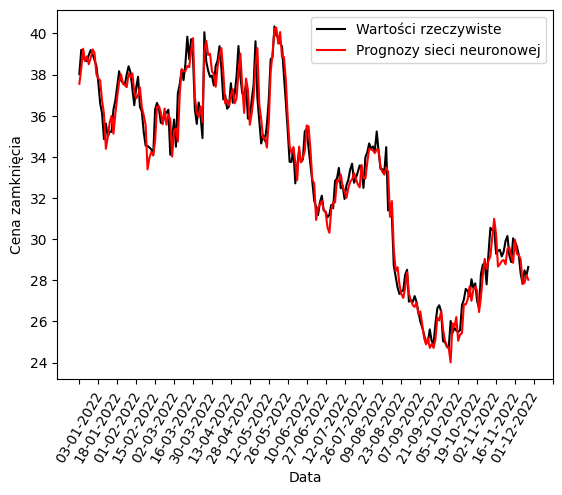

In [87]:
# Utworzenie wykresu wartości prognozowanych i rzeczywistych
plt.plot(data_test.index, y_test, c='k')
plt.plot(data_test.index, predictions, c='r')
plt.xticks(range(0, 252, 10), rotation=60)
plt.xlabel('Data')
plt.ylabel('Cena zamknięcia')
plt.legend(['Wartości rzeczywiste', 'Prognozy sieci neuronowej'])
plt.show()